<a target="_blank" href="https://colab.research.google.com/github/raghavbali/mastering_llms_workshop/blob/main/docs/module_03_instruction_tuning_and_alignment/02_RLHF_phi2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Quick Overview of RLFH

The performance of Language Models until GPT-3 was kind of amazing as-is. What the models of were essentially lacking was the aspect of **alignment**. The language generation aspect was particularly challenging due to heavy hallucinations, toxicity, etc.

The authors of the seminal work **[InstructGPT](https://arxiv.org/pdf/2203.02155)** basically focussed on this aspect of aligning the language models to user's intructions (hence the name!). Their work showcased how we can further fine-tune such models in a supervised way leverage human feedback and reinforcement learning to align them.

## High-Level Overview of the Setup

<img src="../assets/03_instruct_gpt_rlhf.png">

> Source: https://arxiv.org/pdf/2203.02155

## Key Concepts:

- **Reinforcement Learning (RL)**: A machine learning paradigm where an agent learns to make decisions by performing actions and receiving _rewards or penalties_ .
- **Human Feedback**: Evaluations provided by humans that guide the learning process, ensuring the model's outputs align with human expectations and preferences.

## How Does this Actually Work? Show Me Examples Please?

### Standard Supervised Learning:
- Input: "Generate a story about a dragon and a knight."
- Output: The model generates a story based on its training data.


### Reinforcement Learning From Human Feedback:
- Input: "Generate a story about a dragon and a knight."
- Initial Output: The model generates a story.
- Human Feedback: A human rates the story on coherence, creativity, and engagement.
- Adjusted Output: The model refines its story generation based on the feedback, leading to more engaging and coherent stories over time.

As pointed out in the figure above, one of the ways of bringing this alignment is through:
- Training a **reward model** using a Human labelled dataset.
    - This dataset basically contains rank ordered responses to different inputs to the model
- The reward model learns to predict human preferences based on the provided human feedback by assigning a score (reward) to the outputs of the language model.
-  The output of the reward model is then used to update the policy of the language model (agent) to align with the human feedback (exploration vs exploitation)


<img src="https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/trl_overview.png">

> Source: https://huggingface.co/docs/trl/en/quickstart

## PPO vs DPO

There are different ways of performing policy optimisation. The original work follows Proximal Policy Optimisation which requires a separate reward model to tune the Language Model. DPO or Direct Policy Optimisation directly applies updates to the language model thus removing the need for a separate reward model.

> Read more about RL and KL Divergence to understand the topic better


> The KL-divergence between the two outputs is used as an _additional reward signal_ to make sure the generated responses don’t deviate too far from the reference language model.

# Quick Hello World Using PPO

> Can we improve alignment of Phi-1.5?

> Adapted from:
> [[1](https://huggingface.co/docs/trl/en/quickstart)], [[2](https://github.com/antndlcrx/oxford-llms-workshop/blob/main/materials/seminars/day_3/8_LLMs%20alignment%20with%20RLHF.ipynb)]

**NOTE**: Ensure you have high-capacity GPU available for this notebook!

## Install Dependencies

In [ ]:
# !pip install -U trl==0.11 datasets==4.0.0 accelerate==1.10.0 peft==0.17.0 bitsandbytes==0.47.0  tensorboardX==2.6.2.2

In [ ]:
# !pip3 install matplotlib

In [17]:
import torch
torch.__version__

'2.2.0+cu121'

In [3]:
import trl
trl.__version__

'0.11.0'

## Import Packages

In [1]:
import random
import torch
import time
import os
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from random import choices
import matplotlib.pyplot as plt
import numpy as np

tqdm.pandas()

from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, pipeline
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead, create_reference_model
from trl.core import LengthSampler

## Configs

In [5]:
text_input_length = 5
text_output_length = 20
seed = 42

sentiment_pipe_kwargs = {
    "top_k": None, 
    "function_to_apply": "none",
    'return_all_scores':False
}
# microsoft/Phi-3-mini-4k-instruct
ppo_config = PPOConfig(
    model_name="openai-community/gpt2",#"microsoft/phi-2", 
    steps=100,
    learning_rate=1.41e-5, 
    remove_unused_columns=True,
    log_with="tensorboard",
    project_kwargs={"logging_dir": "./logs"},
)

generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
}

ALIGNED_MODEL_NAME = f"aligned-{ppo_config.model_name.split('/')[1]}"

In [6]:
from huggingface_hub import notebook_login

notebook_login()

## Download Models

In [7]:
model = AutoModelForCausalLMWithValueHead.from_pretrained(
    ppo_config.model_name,
    cache_dir="/workspace/"
)
# create a reference model
ref_model = create_reference_model(model, num_shared_layers=6)
tokenizer = AutoTokenizer.from_pretrained(
    ppo_config.model_name,
    cache_dir="/workspace/"
)

tokenizer.pad_token = tokenizer.eos_token
generation_kwargs["pad_token_id"] = tokenizer.eos_token_id

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/548M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [8]:
!nvidia-smi

Sun Aug 17 07:38:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     On  |   00000000:56:00.0 Off |                    0 |
|  0%   31C    P8             22W /  300W |       3MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Prepare Dataset

In [9]:
def prepare_dataset(
    tokenizer, dataset_name="imdb", input_min_text_length=2, input_max_text_length=8
):
    # load imdb with datasets
    ds = load_dataset(dataset_name, split="train",cache_dir='/workspace')
    ds = ds.rename_columns({"text": "review"})
    ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)

    input_size = LengthSampler(input_min_text_length, input_max_text_length)

    def tokenize(sample):
        sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    ds = ds.map(tokenize, batched=False)
    ds.set_format(type="torch")
    return ds

In [10]:
dataset = prepare_dataset(tokenizer)


def data_collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

Map:   0%|          | 0/24895 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1168 > 1024). Running this sequence through the model will result in indexing errors


## Setup PPO Trainer

In [11]:
ppo_trainer = PPOTrainer(ppo_config,
                         model,
                         ref_model,
                         tokenizer,
                         dataset,
                         data_collator=data_collator,
                         )

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:193: FutureWarning: `PPOTrainer` is deprecated and will be removed in trl v0.12. Please use `PPOv2Trainer` instead.
  warnings.warn(


In [12]:
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else "cpu"  
else:
    device = ppo_trainer.accelerator.device
print(f"Accelerator Device={device}")

Accelerator Device=0


In [13]:
ppo_trainer.accelerator.device

device(type='cuda')

### Setup Reward Model and Utils

### Reward Assignment

The objective is to align our text generation model towards the alignment signal provided.
To do so, we need to assign a corresponding reward to each output logit

In [15]:
## Get the Reward Model
distilbert_tokenizer = AutoTokenizer.from_pretrained("lvwerra/distilbert-imdb",eos_token='</s>')
sentiment_pipe = pipeline("text-classification")
#, "lvwerra/distilbert-imdb", tokenizer=distilbert_tokenizer,device=device)

# test out the pipeline
text = "this movie was really bad!!"
output = sentiment_pipe(text, **sentiment_pipe_kwargs)
output

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


[{'label': 'NEGATIVE', 'score': 4.6659016609191895},
 {'label': 'POSITIVE', 'score': -3.7129852771759033}]

## Time to Align using RLHF : PPO
- Get a batch of queries and prepare training input
- Get the query responses from the policy (model to be aligned)
- Join query and responses and tokenize for reward based on sentiment analysis
- Optimize policy with PPO using the (query, response, reward) triplet
- Log all the training statistics

In [16]:
from tqdm.notebook import tqdm

In [17]:
output_min_length = 10
output_max_length = 25
num_steps = 5
overall_rewards = list()
output_length_sampler = LengthSampler(output_min_length, output_max_length)

In [18]:
generation_kwargs["pad_token_id"]= tokenizer.eos_token_id

In [19]:
!nvidia-smi

Sun Aug 17 07:39:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     On  |   00000000:56:00.0 Off |                    0 |
|  0%   35C    P0             75W /  300W |    1927MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [20]:
for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    if epoch >= num_steps:
        break

    query_tensors = batch["input_ids"]

    #### Get response from gpt2
    response_tensors = []
    for query in query_tensors:
        gen_len = output_length_sampler()
        generation_kwargs["max_new_tokens"] = gen_len
        response = ppo_trainer.generate(query, **generation_kwargs)
        response_tensors.append(response.squeeze()[-gen_len:])
    batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

    #### Compute sentiment score
    texts = [q + r for q, r in zip(batch["query"], batch["response"])]
    pipe_outputs = sentiment_pipe(texts, **sentiment_pipe_kwargs)
    rewards = list()
    for output in pipe_outputs:
        if output[0]['score']>output[1]['score']:
            if output[0]['label'] == 'POSITIVE':
                rewards.append(torch.tensor(4*output[0]['score']))
            else:
                rewards.append(torch.tensor(0.5*output[0]['score']))
        elif output[1]['score']>output[0]['score']:
            if output[1]['label'] == 'POSITIVE':
                rewards.append(torch.tensor(4*output[1]['score']))
            else:
                rewards.append(torch.tensor(0.5*output[0]['score']))

    overall_rewards.append(rewards)
    #PPO step
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)

    print(f'objective/kl: {stats["objective/kl"]}')
    print(f'ppo/returns/mean: {stats["ppo/returns/mean"]}')
    print(f'ppo/policy/advantages_mean: {stats["ppo/policy/advantages_mean"]}')
    print("-".join("" for x in range(100)))

    ppo_trainer.log_stats(stats, batch, rewards)

0it [00:00, ?it/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


objective/kl: 0.0
ppo/returns/mean: 1.5722572803497314
ppo/policy/advantages_mean: -5.84645860612909e-08
---------------------------------------------------------------------------------------------------
objective/kl: -0.002945292741060257
ppo/returns/mean: 1.535487413406372
ppo/policy/advantages_mean: 1.3586353375671933e-08
---------------------------------------------------------------------------------------------------
objective/kl: -0.05121579021215439
ppo/returns/mean: 1.119126796722412
ppo/policy/advantages_mean: 8.762297909470362e-08
---------------------------------------------------------------------------------------------------
objective/kl: 0.01759793609380722
ppo/returns/mean: 1.6412243843078613
ppo/policy/advantages_mean: 3.377779478341836e-08
---------------------------------------------------------------------------------------------------
objective/kl: 0.0692419707775116
ppo/returns/mean: 2.6154704093933105
ppo/policy/advantages_mean: -1.163447365115644e-07
---------

### Plot Reward Distribution

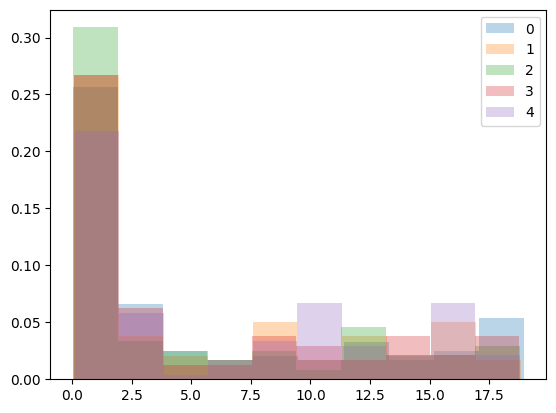

In [21]:
for idx,epoch_rewards in enumerate(overall_rewards):
    plt.hist([i.item() for i in epoch_rewards], density=True, alpha=0.3)
plt.legend(range(10))
plt.show()

### Compare Rewards

In [22]:
bs = 16
game_data = dict()
dataset.set_format("pandas")
df_batch = dataset[:].sample(bs)
game_data["query"] = df_batch["query"].tolist()
query_tensors = df_batch["input_ids"].tolist()

response_tensors_ref, response_tensors = [], []

#### get response from phi2 and phi2_ref
for i in range(bs):
    gen_len = output_length_sampler()
    output = ref_model.generate(
        torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device),
        # max_new_tokens=gen_len,
        **generation_kwargs
    ).squeeze()[-gen_len:]
    response_tensors_ref.append(output)
    output = model.generate(
        input_ids=torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device),
        # max_new_tokens=gen_len,
        **generation_kwargs
    ).squeeze()[-gen_len:]
    response_tensors.append(output)

#### decode responses
game_data["response (before)"] = [
    tokenizer.decode(response_tensors_ref[i]) for i in range(bs)
]
game_data["response (after)"] = [
    tokenizer.decode(response_tensors[i]) for i in range(bs)
]

#### sentiment analysis of query/response pairs before/after
texts = [q + r for q, r in zip(game_data["query"], game_data["response (before)"])]
# game_data["rewards (before)"] = [
#     output[1]["score"] for output in sentiment_pipe(texts, **sentiment_pipe_kwargs)
# ]
game_data["rewards (before)"]=list()
for output in sentiment_pipe(texts, **sentiment_pipe_kwargs):
        if output[0]['score']>output[1]['score']:
            if output[0]['label'] == 'POSITIVE':
                game_data["rewards (before)"].append(4*output[0]['score'])
            else:
                game_data["rewards (before)"].append(0.5*output[0]['score'])
        elif output[1]['score']>output[0]['score']:
            if output[1]['label'] == 'POSITIVE':
                game_data["rewards (before)"].append(4*output[1]['score'])
            else:
                game_data["rewards (before)"].append(0.5*output[0]['score'])

texts = [q + r for q, r in zip(game_data["query"], game_data["response (after)"])]

game_data["rewards (after)"]=list()
for output in sentiment_pipe(texts, **sentiment_pipe_kwargs):
        if output[0]['score']>output[1]['score']:
            if output[0]['label'] == 'POSITIVE':
                game_data["rewards (after)"].append(4*output[0]['score'])
            else:
                game_data["rewards (after)"].append(0.5*output[0]['score'])
        elif output[1]['score']>output[0]['score']:
            if output[1]['label'] == 'POSITIVE':
                game_data["rewards (after)"].append(4*output[1]['score'])
            else:
                game_data["rewards (after)"].append(0.5*output[0]['score'])


# store results in a dataframe
df_results = pd.DataFrame(game_data)
df_results

,query,response (before),response (after),rewards (before),rewards (after)
0,This really is,to tackle is whether or not the metrics are e...,director. Seems very ofroly horny in yet.,1.418013,8.177265
1,"This film, was",employed\n\n\nRecent Examples on the Web\n\nCh...,-1 SexualizationPostureterSlut1 and -n,1.118258,1.620377
2,When i first went,they pitched me last week under the knowledge...,"the break through a wall or better, the racis...",1.447953,12.225261
3,The only aspect of this film,projects is how not to mention that it's alre...,aquin doesn't has been whether it's a our-conc...,2.179706,1.220954
4,THE SCREAMING SK,Harry cries out into the shadows in agony. A ...,\n\n\n35\n\nWHAT POSSIBLE THETHROW,1.602157,1.611169
5,Bette Midler is,on Greasy Side Of Stone and titles legends Sc...,Unix Master: AACMAINT $ MacBook | Macintosh |...,1.582586,0.983169
6,"Firstly, this","you want to change, and\n\nfigures you want t...","FERENC by Usenoxia powered, a commercial telev...",10.596127,1.523673
7,Or at least one of the,ural and sexual statements. Parasitism is an o...,.\n\n\nSo I haven't heard of spinning the dead,0.125203,1.407147
8,I read in the papers,the dangers from using sexual desire in a pro...,\n19. Lady Barrett sloppily remarks that only ...,2.330472,1.469326
9,Don't,take it as lying. Ecclestone merely asserts t...,rely solely on your gut or Pr operator) also ...,1.631847,1.371802


### Save Aligned Model Objects

In [25]:
model.save_pretrained(ALIGNED_MODEL_NAME)
tokenizer.save_pretrained(ALIGNED_MODEL_NAME)

('aligned-gpt2/tokenizer_config.json',
 'aligned-gpt2/special_tokens_map.json',
 'aligned-gpt2/vocab.json',
 'aligned-gpt2/merges.txt',
 'aligned-gpt2/added_tokens.json',
 'aligned-gpt2/tokenizer.json')

In [ ]:
# uncomment if you would like to push to HF Hub
# model.push_to_hub(ALIGNED_MODEL_NAME,commit_message="PPO alignment done")
# tokenizer.push_to_hub(ALIGNED_MODEL_NAME,commit_message="PPO alignment done")

## Generate and Compare Aligned vs Non-Aligned Models

In [23]:
from IPython.display import display, Markdown

In [27]:
# double checking if we are still refering to same model
# assign "aligned-phi-2" if directly checking results
ALIGNED_MODEL_NAME="aligned-phi-2"
ALIGNED_MODEL_NAME

'aligned-phi-2'

In [28]:
hub_model = AutoModelForCausalLMWithValueHead.from_pretrained(f'raghavbali/{ALIGNED_MODEL_NAME}',
                                                              cache_dir="/workspace/").to(device)
# create a reference model
hub_tokenizer = AutoTokenizer.from_pretrained(f'raghavbali/{ALIGNED_MODEL_NAME}',
                                              cache_dir="/workspace/")

hub_tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.15G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at raghavbali/aligned-phi-2 were not used when initializing PhiForCausalLM: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing PhiForCausalLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing PhiForCausalLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.15G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

In [29]:
reviews = [
    "If I have to review this movie, I would",
    "The actors in this movie",
    "The makers of this movie",
    "I went to this movie for",
    "The thing about this movie",
    "Here are my 2 cents on the movie",
    
]

In [30]:
for review in reviews:
    inputs = hub_tokenizer(review, return_tensors="pt", return_token_type_ids=False).to(device)
    print("----ALIGNED-MODEL ----")
    outputs = hub_model.generate(**inputs,max_new_tokens=25,temperature=0.8,do_sample=True)
    display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))
    print("---- NON-ALIGNEDD-MODEL ----")
    outputs = ref_model.generate(**inputs, max_new_tokens=25,temperature=0.8,do_sample=True)
    display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))
    print("---- END ----")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


----ALIGNED-MODEL ----


If I have to review this movie, I would suggest the following to the directors, producers and exhibitors:
A good movie is always a combination of the best elements of

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- NON-ALIGNEDD-MODEL ----


If I have to review this movie, I would be going for the latter. I just found out that after all, I'm really not that into this. I'm not

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- END ----
----ALIGNED-MODEL ----


The actors in this movie are really amazing. There's John Vickers, who plays the main character Richard, and Jean-Marie Amalberti

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- NON-ALIGNEDD-MODEL ----


The actors in this movie are really important for the characters and the story of this movie. And this is the way it is with this film and this

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- END ----
----ALIGNED-MODEL ----


The makers of this movie have done a wonderful job in bringing this story to life. I hope you all get a chance to watch it and enjoy it

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- NON-ALIGNEDD-MODEL ----


The makers of this movie, and the actors who have worked with him, have been a lot of fun to work with. One of the things I

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- END ----
----ALIGNED-MODEL ----


I went to this movie for the first time, and it was great to see the story come to life on the big screen. The performances were amazing,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- NON-ALIGNEDD-MODEL ----


I went to this movie for the first time in my life, and I was very happy. It was not a great feeling. I guess it was a

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- END ----
----ALIGNED-MODEL ----


The thing about this movie is it shows us how some people were very proud of being from a certain place and how some people didn't like it.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- NON-ALIGNEDD-MODEL ----


The thing about this movie is that it's very, very, very different than the movies you've seen in Hollywood before. You know, we've

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- END ----
----ALIGNED-MODEL ----


Here are my 2 cents on the movie.
The main idea of the movie is how to get the most out of your life. To make the most money,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- NON-ALIGNEDD-MODEL ----


Here are my 2 cents on the movie:

2/2

If your story has had a lot of success or you've managed to get a lot

---- END ----
